# BA, 512²

| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  12/05/2024          |
| Updated |  03/23/2025          |

In [1]:
#===============================================================================
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import pandas as pd

root = 'src'
problem = 'BA'
res = 512
n_p = 'np1'
runs = {
    f'dust_particles/{n_p}': {
        'ls': 'dotted',
        'codes' : {
            'Athena':       'tab:green',
            'Athena++':     'tab:red',
            'Pencil':       'tab:blue',
            'PLUTO':        'tab:pink'
        }
    },
    'dust_fluid': {
        'ls': 'solid',
        'codes' : {
            'Athena++':     'tab:purple',
            'FARGO3D':      'tab:olive',
            'Idefix':       'tab:orange',
            'LA-COMPASS':   'tab:cyan',
            'PLUTO':        'tab:brown'
        }
    }
}

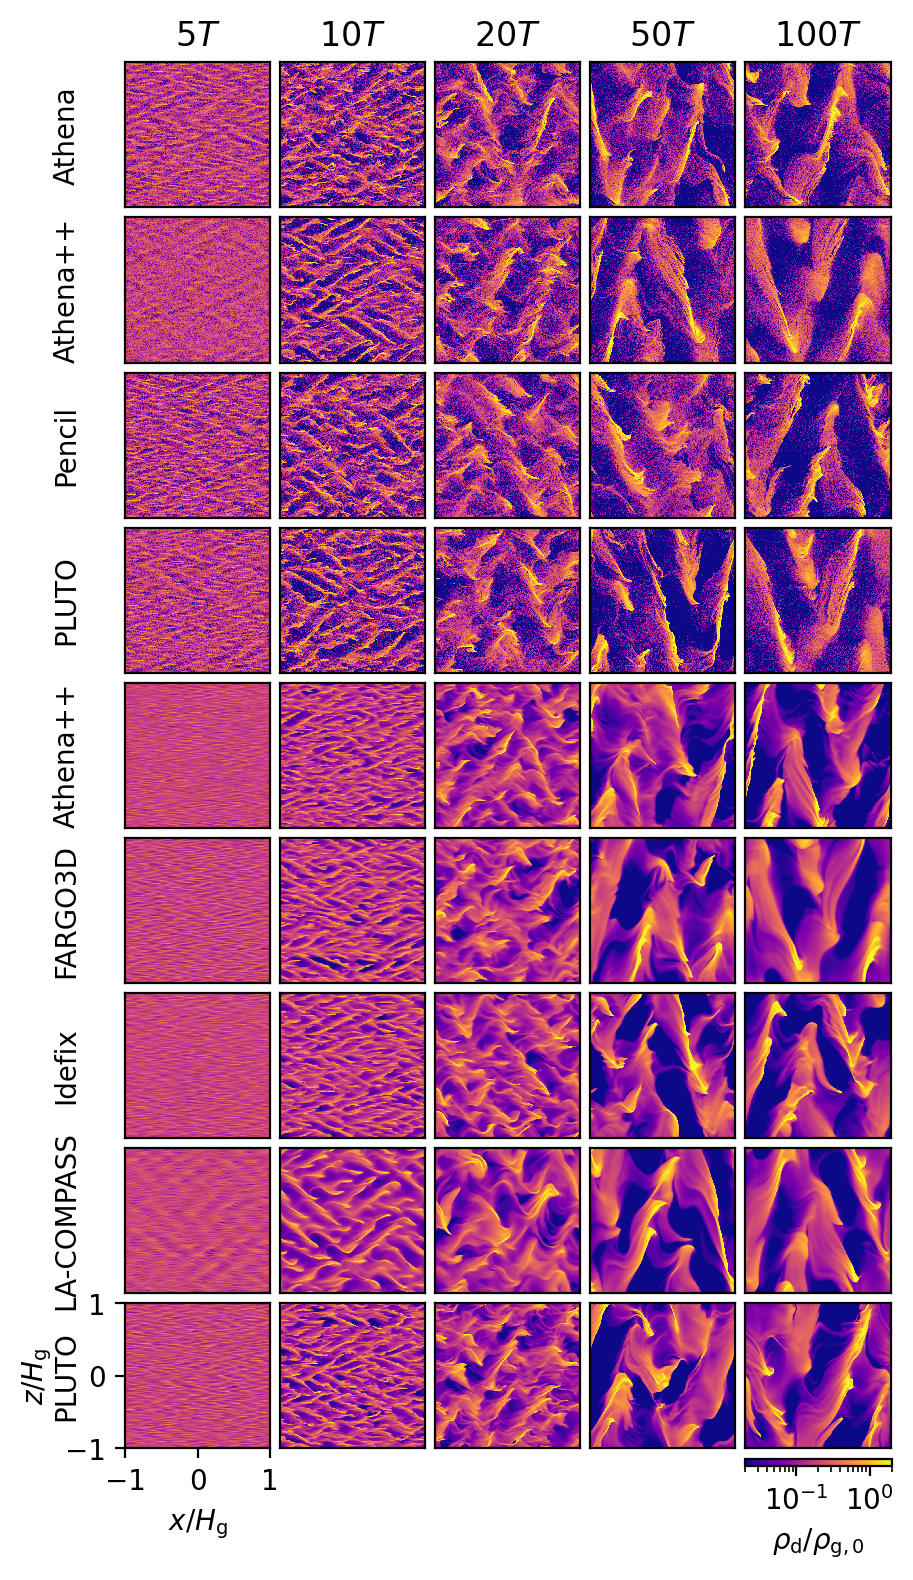

In [3]:
#===============================================================================
times = [5, 10, 20, 50, 100]
vmin, vmax = 2e-2, 2e0 # BA CDF(rhop) > 90%; CDF(rhop) < 1%
nrows = 0
for key, value in runs.items():
    for code in value['codes']:
        nrows += 1

# Plot
fig = plt.figure(figsize=(8, 9*nrows/9), dpi=200)
ax_grid = AxesGrid(fig, 111, nrows_ncols=(nrows, len(times)), axes_pad=0.05,
                   share_all=True, label_mode='1')
j = 0
for key, value in runs.items():
    for code in value['codes']:
        path = f'{root}/{key}/{code}'
        row = j*len(times)
        for i, time in enumerate(times):
            if j == 0:
                ax_grid[i].set_title(rf'{time}$T$')
            if i == 0:
                ax_grid[row].text(-0.5, 0.5, f'{code}', rotation='vertical',
                                  va='center', transform=ax_grid[row].transAxes)
            snapshot = np.load(f'{path}/{time}.npz')
            x = snapshot['x']
            z = snapshot['z']
            rhop = snapshot['rhop']
            clip = np.clip(rhop, vmin, vmax)
            pcm = ax_grid[row+i].pcolormesh(x, z, clip, cmap='plasma',
                                            rasterized=True,
                                            norm=colors.LogNorm(vmin=vmin,
                                                                vmax=vmax))
            ax_grid[row+i].tick_params(bottom=False, left=False)
        j += 1

# Format plots
x1 = ax_grid[-1].get_position().x1 - 0.116
plt.colorbar(pcm, orientation='horizontal', shrink=0.118, anchor=(x1, -0.088),
             label=r'$\rho_\mathrm{d}/\rho_\mathrm{g,0}$')
bot_left = len(ax_grid)-len(times)
ax_grid[bot_left].set(xlabel=r'$x/H_\mathrm{g}$', ylabel=r'$z/H_\mathrm{g}$')
ax_grid[bot_left].tick_params(bottom=True, left=True)
plt.savefig(f'figs/{problem}-{res}_snapshots.png', dpi=600, bbox_inches='tight',
            pad_inches=0.01)

Athena samples
	  Total: 10001
	Strided: 667
	Per 10T: 1000
Athena++ samples
	  Total: 2000
	Strided: 667
	Per 10T: 222
Pencil samples
	  Total: 2925
	Strided: 732
	Per 10T: 292
PLUTO samples
	  Total: 1002
	Strided: 501
	Per 10T: 111
Athena++ samples
	  Total: 100014
	Strided: 633
	Per 10T: 10001
FARGO3D samples
	  Total: 631
	Strided: 631
	Per 10T: 63
Idefix samples
	  Total: 1002
	Strided: 501
	Per 10T: 100
LA-COMPASS samples
	  Total: 31401
	Strided: 641
	Per 10T: 3489
PLUTO samples
	  Total: 1001
	Strided: 501
	Per 10T: 100


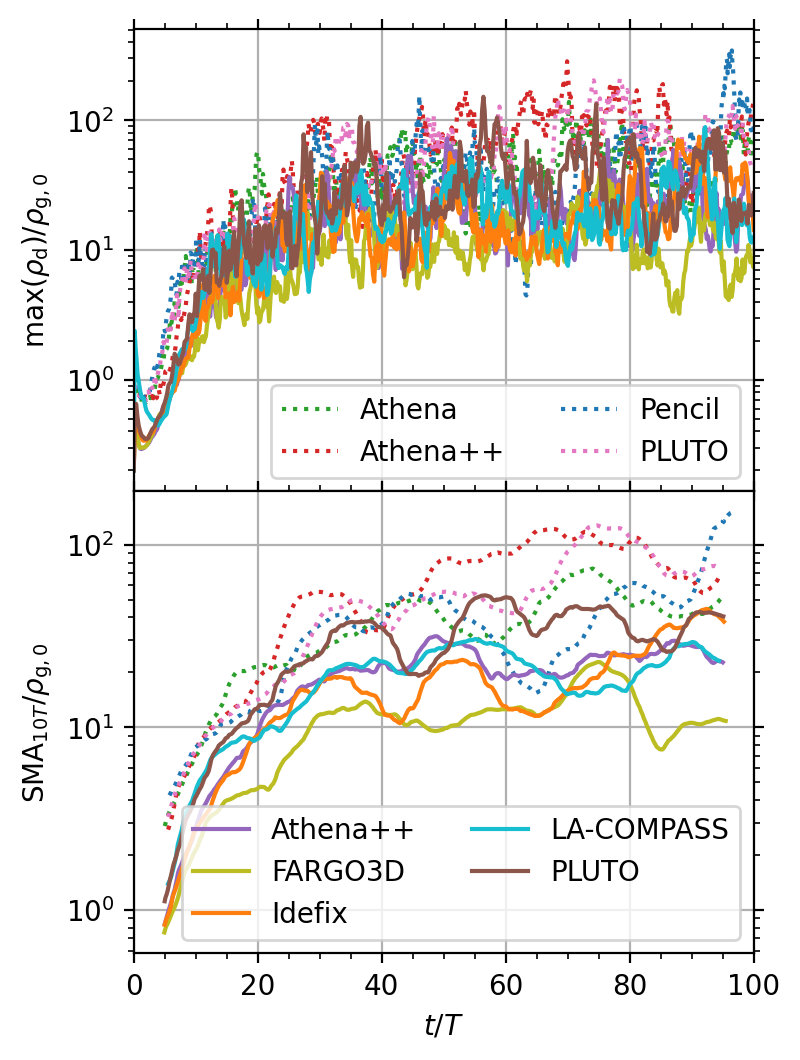

In [6]:
#===============================================================================
def print_samples(code, t, step, dt, window):
    """Print the number of samples in the time series."""
    print(f'{code} samples\n=======================')
    print(f'\t  Total: {len(t)}')
    print(f'\tStrided: {len(t[::step])}')
    print(f'\tPer {dt}T: {window}')

diag = True
dt = 10  # [T]

# Lowest cadence
path = f'{root}/dust_fluid/FARGO3D'
n_min = len(np.load(f'{path}/time_series.npz')['t'])

# Plot
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(4, 6), dpi=200)
for k, (key, value) in enumerate(runs.items()):
    for code, color in value['codes'].items():
        path = f'{root}/{key}/{code}'
        data = np.load(f'{path}/time_series.npz')
        t = data['t']
        # Strided
        step = len(t)//n_min
        if step < 2:
            step = 1 if len(t)%n_min/n_min < 0.5 else 2
        axs[0].plot(t[::step], data['maxrhop'][::step], c=color, ls=value['ls'])
        # SMA
        window = len(t)//int(t[-1]/dt)
        print_samples(code, t, step, dt, window) if diag else None
        df = pd.DataFrame(data=data['maxrhop'], index=t)
        df['sma'] = df.rolling(window, center=True).mean()
        axs[1].plot(df['sma'], c=color, ls=value['ls'])
        axs[k].plot([], [], c=color, label=code, ls=value['ls'])

# Format plots
for ax in axs:
    ax.grid()
    ax.legend(ncol=2)
    ax.minorticks_on()
    ax.set(yscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)
axs[0].set(ylabel=rf'$\max(\rho_\mathrm{{d}})/\rho_\mathrm{{g,0}}$')
axs[1].set(xlabel=r'$t/T$', xlim=(0, 100), #ylim=(3e-2, 3e2),
           ylabel=rf'$\mathrm{{SMA}}_{{{dt}T}}/\rho_\mathrm{{g,0}}$')
fig.subplots_adjust(hspace=0)
plt.savefig(f'figs/{problem}-{res}_time_series.pdf', bbox_inches='tight',
            pad_inches=0.01)
plt.savefig(f'figs/{problem}-{res}_time_series.png', dpi=600, bbox_inches='tight',
            pad_inches=0.01)

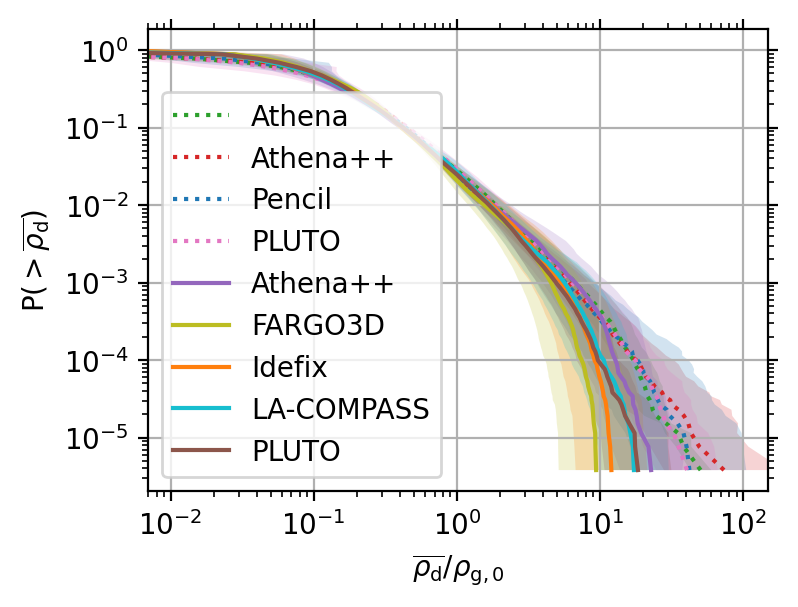

In [5]:
#===============================================================================
times = [20, 50, 100]  # [T]

# Plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
indices = -np.unique(np.logspace(np.log2(res**2), 0, num=100, base=2, dtype=int))
for key, value in runs.items():
    for code, color in value['codes'].items():
        path = f'{root}/{key}/{code}'
        rhops = []
        for i, time in enumerate(times):
            snapshot = np.load(f'{path}/{time}.npz')
            sort = np.sort(snapshot['rhop'], axis=None)
            rhops.append(sort)
        rhops = np.asarray(rhops)
        avgs = np.average(rhops, axis=0)
        cdf = np.linspace(1, 0, avgs.size, endpoint=False)
        log = np.log(np.clip(rhops, 1e-45, None))
        std_log = np.std(log, axis=0)
        stds = np.clip(np.exp(std_log), None, 3)
        cdf = np.take_along_axis(cdf, indices, 0)
        avgs = np.take_along_axis(avgs, indices, 0)
        stds = np.take_along_axis(stds, indices, 0)
        ax.plot(avgs, cdf, c=color, label=code, ls=value['ls'])
        ax.fill_betweenx(cdf, avgs/stds, avgs*stds, alpha=0.2, color=color,
                         ec=None)

# Format plots
ax.grid()
ax.legend()
ax.minorticks_on()
ax.set(xlim=(7e-3, 1.5e2), xscale='log', yscale='log', 
       xlabel=r'$\overline{\rho_\mathrm{d}}/\rho_\mathrm{g,0}$',
       ylabel=r'P$(>\overline{\rho_\mathrm{d}})$')
ax.tick_params(axis='both', which='both', top=True, right=True)
plt.savefig(f'figs/{problem}-{res}_CDF.pdf', bbox_inches='tight',
            pad_inches=0.01)
plt.savefig(f'figs/{problem}-{res}_CDF.png', dpi=600, bbox_inches='tight',
            pad_inches=0.01)

## Data compliance

### Pencil

In [14]:
code = 'Pencil'
path = f'{root}/dust_particles/np1/{code}'
folder = 'Olivia_runs'
times = [5, 10, 20, 50, 100]

# Inspect
# np.load(f'{path}/{folder}/{times[0]}.npz', mmap_mode='r').files
# snap = np.load(f'{path}/old/{times[0]}.npz', mmap_mode='r')
# snap['array3'].shape
# out = np.reshape(snap['rhop'], (512, 512))
# np.shape(out)

# # Standardize
for time in times:
    snap = np.load(f'{path}/{folder}/{time}.npz')
    np.savez_compressed(f'{path}/{time}', x=snap['array1'], z=snap['array2'],
                        rhop=snap['array3'])

In [16]:
code = 'Pencil'
path = f'{root}/dust_particles/np1/{code}'
folder = 'Olivia_runs'
fname = 'time_series.npz'

# Inspect
time_series = np.load(f'{path}/{folder}/{fname}', mmap_mode='r')
# time_series['array1']

# Standardize
time_series = np.load(f'{path}/{folder}/{fname}')
np.savez_compressed(f'{path}/time_series', t=time_series['array1']/2/np.pi,
                    maxrhop=time_series['array2'])


### PLUTO

In [ ]:
code = 'PLUTO'
path = f'{root}/dust_particles/{n_p}/{code}'
folder = 'NP1_V3'
times = [5, 10, 20, 50, 100]

# Inspect
# np.load(f'{path}/old/{times[0]}.npz', mmap_mode='r').files
# snap = np.load(f'{path}/old/{times[0]}.npz', mmap_mode='r')
# out = np.reshape(snap['rhop'], (512, 512))
# np.shape(out)

# # Standardize
for time in times:
    snap = np.load(f'{path}/{folder}/{time}.npz')
    np.savez_compressed(f'{path}/{time}', x=snap['x'], z=snap['x'],
                        rhop=snap['rhop'].reshape(512, 512).transpose())

In [11]:
code = 'PLUTO'
path = f'{root}/dust_particles/{n_p}/{code}'
folder = 'NP1_V3'
fname = 'time_series.npz'

# Inspect
np.load(f'{path}/{folder}/time_series.npz', mmap_mode='r')

# Standardize
time_series = np.load(f'{path}/NP1_V3/{fname}')
np.savez_compressed(f'{path}/time_series', t=time_series['t']/2/np.pi,
                    maxrhop=time_series['maxrhop'])


### Idefix

In [3]:
code = 'Idefix'
path = f'{root}/dust_fluid/{code}'
times = [0, 5, 10, 20, 50, 100]

# Load separate grid
grid = np.load(f'{path}/old/grid.npz', mmap_mode='r')#.files
x = grid['x']
z = grid['z']

# Inspect
# np.load(f'{path}/old/{prefix}{times[0]}{suffix}', mmap_mode='r').files
# np.load(f'{path}/old/gas_{times[0]}{suffix}', mmap_mode='r').files
# np.shape(snap['arr_0'])

# # Standardize
for i, time in enumerate(times):
    gas = np.load(f'{path}/old/gas_{time}.npz')
    dust = np.load(f'{path}/old/dust_{time}.npz')
    np.savez_compressed(f'{path}/{time}', x=x, z=z,
                        ux=gas['vx_gas'].transpose(),
                        uz=gas['vz_gas'].transpose(),
                        vx=dust['vx_dust'].transpose(),
                        vz=dust['vz_dust'].transpose(),
                        rhog=gas['rho_gas'].transpose(),
                        rhop=dust['rho_dust'].transpose())

In [4]:
code = 'Idefix'
path = f'{root}/dust_fluid/{code}'
fname = 'time_series.npz'

# Inspect
np.load(f'{path}/old/{fname}', mmap_mode='r').files

# Standardize
time_series = np.load(f'{path}/old/{fname}')
np.savez_compressed(f'{path}/time_series', t=time_series['time'],
                    maxrhop=time_series['rho_max'])


### PLUTO

In [10]:
code = 'PLUTO'
path = f'{root}/dust_fluid/{code}'
times = [5, 10, 20, 50, 100]

# Inspect
# np.load(f'{path}/old/{times[0]}.npz', mmap_mode='r').files
# snap = np.load(f'{path}/old/{times[0]}.npz', mmap_mode='r')
# out = np.reshape(snap['rhop'], (512, 512))
# np.shape(out)

# Standardize
for time in times:
    snap = np.load(f'{path}/old/{time}.npz')
    np.savez_compressed(f'{path}/{time}', x=snap['x'], z=snap['z'],
                        rhop=snap['rhop'].reshape(512, 512).transpose())